# RF-DETR Fine-tuning on Google Colab

This notebook demonstrates how to fine-tune RF-DETR for drone detection using GPU acceleration on Google Colab.

## Prerequisites
1. Enable GPU runtime: Runtime > Change runtime type > Hardware accelerator > GPU
2. Upload your dataset to Google Drive or prepare it for upload to Colab

In [3]:
# Install required packages
!pip install rfdetr==1.2.1
!pip install supervision==0.26.1
!pip install roboflow
!pip install tensorboard
!pip install rfdetr[onnxexport]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 8.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached ninja-1.11.1.4-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.3/131.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.4 MB/s eta 0:00:

In [16]:
import os
import torch
from google.colab import drive

In [17]:
# Check GPU availability
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Current device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name()}")
    print(f"Device memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("⚠️ GPU not available. Please enable GPU runtime: Runtime > Change runtime type > Hardware accelerator > GPU")

CUDA available: True
Current device: 0
Device name: Tesla T4
Device memory: 14.7 GB


In [18]:
# Mount Google Drive (optional - if your dataset is stored there)
drive.mount('/content/drive')
# If dataset is in Google Drive, set the path accordingly

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
dataset_location = "/content/drive/MyDrive/dataset"

In [5]:
# Verify dataset structure
if os.path.exists(dataset_location):
    print(f"Dataset found at: {dataset_location}")
    print("Dataset structure:")
    for root, dirs, files in os.walk(dataset_location):
        level = root.replace(dataset_location, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        for file in files[:5]:  # Show first 5 files only
            print(f"{subindent}{file}")
        if len(files) > 5:
            print(f"{subindent}... and {len(files)-5} more files")
else:
    print(f"⚠️ Dataset not found at {dataset_location}")
    print("Please upload your dataset using one of the methods above.")

Dataset found at: /content/drive/MyDrive/dataset
Dataset structure:
dataset/
  README.dataset.txt
  README.roboflow.txt
  valid/
    GST_Video_Standard_J4A0104_YUV_20250605204851794_mp4-0004_jpg.rf.d20add3513870cd0dbd8df4af845ba45.jpg
    GST_Video_Standard_J4A0104_YUV_20250605204851794_mp4-0018_jpg.rf.a72b69d414736711f10d8d568462ef8b.jpg
    GST_Video_Standard_J4A0104_YUV_20250605204851794_mp4-0028_jpg.rf.1a91f73293fa45abdd4069c93eb662eb.jpg
    GST_Video_Standard_J4A0104_YUV_20250605220004358_mp4-0002_jpg.rf.745ad61bdbf85f2186d62cb045e5aecf.jpg
    GST_Video_Standard_J4A0104_YUV_20250605204851794_mp4-0032_jpg.rf.30834d9638b3d606055d501499f408cd.jpg
    ... and 6 more files
  train/
    GST_Video_Standard_J4A0104_YUV_20250605220004358_mp4-0006_jpg.rf.e605d5c26871176565819b0eae3ccec8.jpg
    GST_Video_Standard_J4A0104_YUV_20250605204851794_mp4-0035_jpg.rf.8a28f29403d80f22b412f3b22c16914e.jpg
    GST_Video_Standard_J4A0104_YUV_20250605220004358_mp4-0022_jpg.rf.f1d6d74ad4a84245ad3cea2f64

In [20]:
# Import RF-DETR
from rfdetr import RFDETRMedium

In [21]:
if not os.path.exists("/content/drive/MyDrive/output/checkpoint_best_ema.pth"):
  model = RFDETRMedium()
else:
  model = RFDETRMedium(pretrain_weights="/content/drive/MyDrive/output/checkpoint_best_ema.pth")

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


reinitializing detection head with 1 classes


In [22]:
# Training parameters optimized for Colab
# Adjust batch_size based on your GPU memory
# For Colab's free T4 GPU, batch_size=4-8 should work well
model.train(
    output_dir="/content/drive/MyDrive/output",
    dataset_dir=dataset_location,
    epochs=10,              # Increased epochs for better training
    batch_size=4,           # Reduced for better GPU memory usage
    grad_accum_steps=4,     # Increased to simulate larger batch size
    lr=1e-3,                # Slightly reduced learning rate
    device="cuda" if torch.cuda.is_available() else "cpu"  # Explicitly set device

)

reinitializing your detection head with 2 classes.


TensorBoard logging initialized. To monitor logs, use 'tensorboard --logdir /content/drive/MyDrive/output' and open http://localhost:6006/ in browser.
Not using distributed mode
git:
  sha: N/A, status: clean, branch: N/A

Namespace(num_classes=2, grad_accum_steps=4, amp=True, lr=0.001, lr_encoder=0.00015, batch_size=4, weight_decay=0.0001, epochs=10, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='/content/drive/MyDrive/output/checkpoint_best_ema.pth', pretrain_exclude_keys=None, pretrain_keys_modify_to_load=None, pretrained_distiller=None, encoder='dinov2_windowed_small', vit_encoder_num_layers=12, window_block_indexes=None, position_embedding='sine', out_feature_indexes=[3, 6, 9, 12], freeze_encoder=False, layer_norm=True, rms_norm=False, backbone_lora=False, force_no_pretrain=False, dec_layers=4, dim

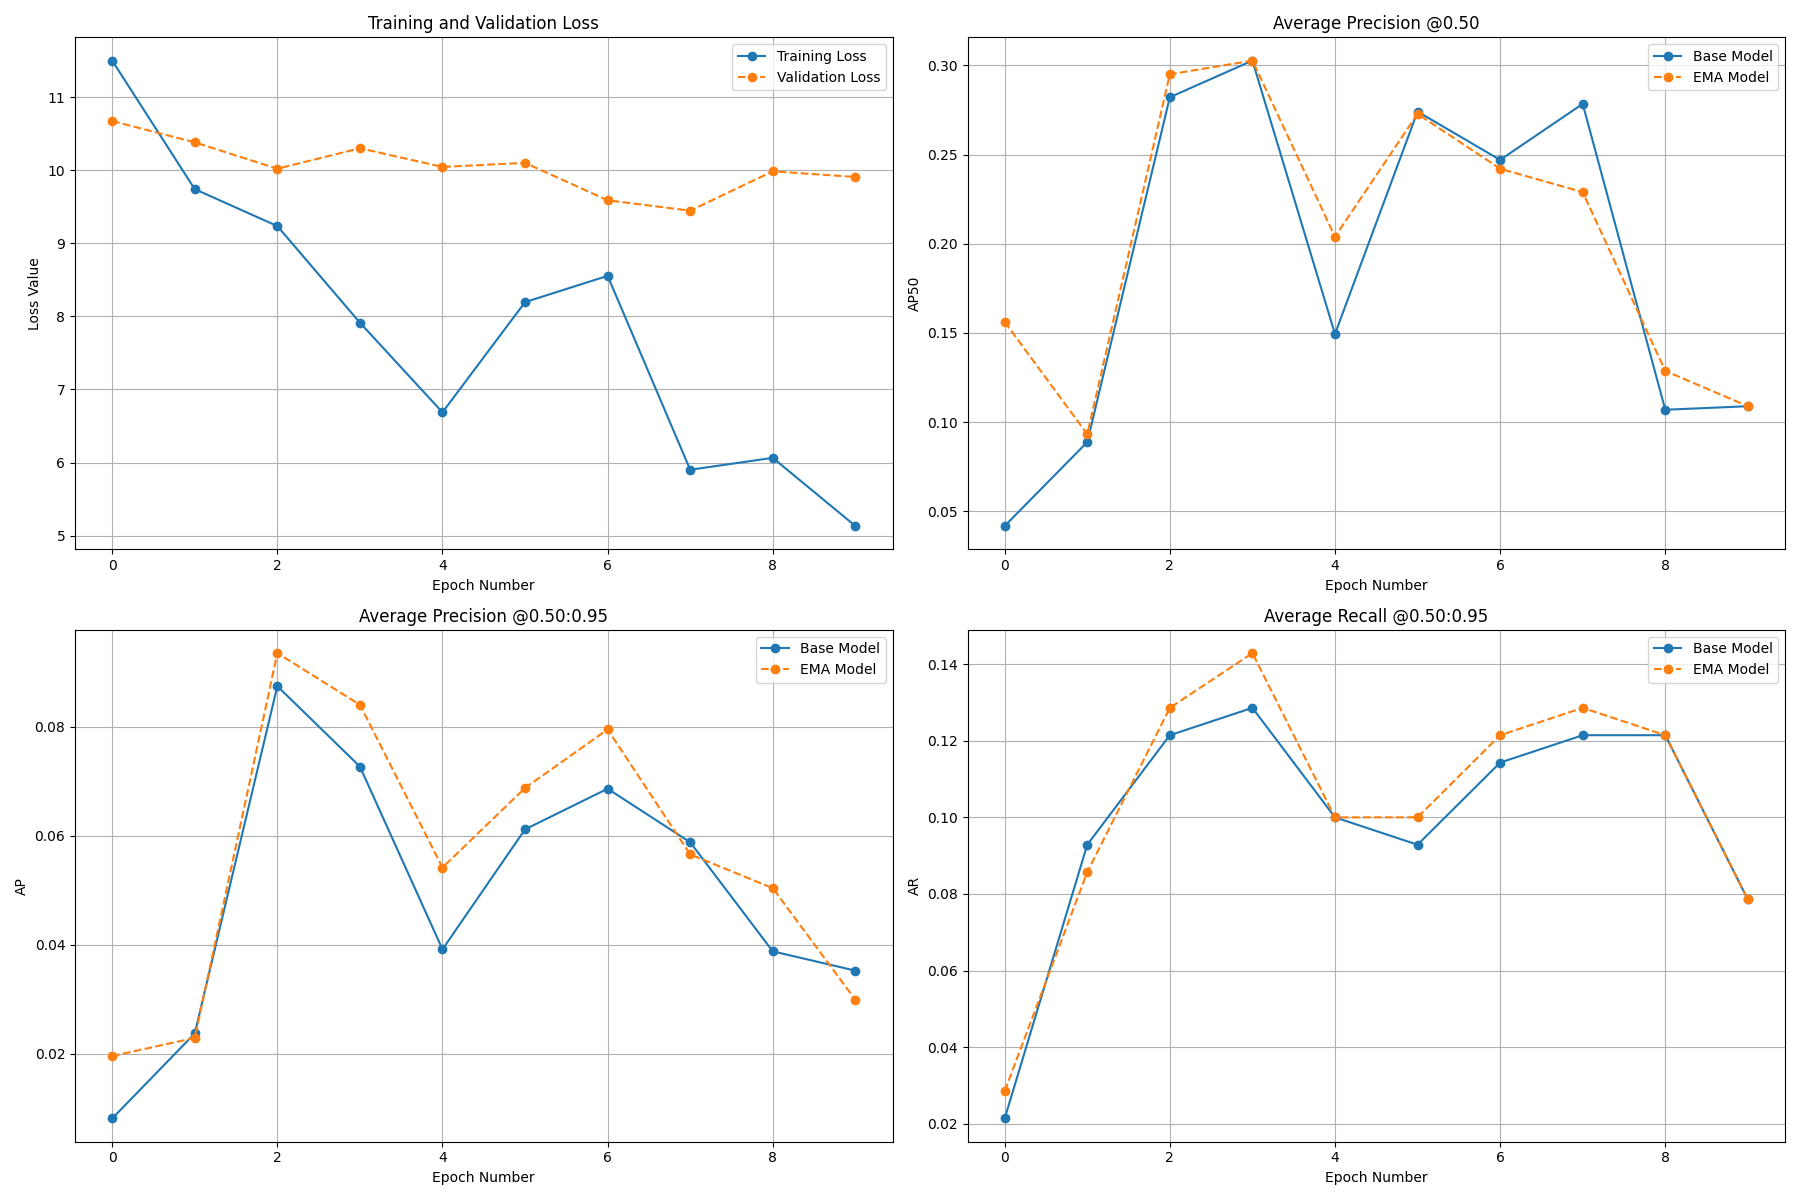

In [23]:
from PIL import Image

Image.open("/content/drive/MyDrive/output/metrics_plot.png")

In [24]:
model = RFDETRMedium(pretrain_weights="/content/drive/MyDrive/output/checkpoint_best_ema.pth")

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


reinitializing detection head with 1 classes


In [26]:
# Load test dataset for evaluation
import supervision as sv

ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset_location}/test",
    annotations_path=f"{dataset_location}/test/_annotations.coco.json",
)

In [27]:
# Optimize model for inference
model.optimize_for_inference()

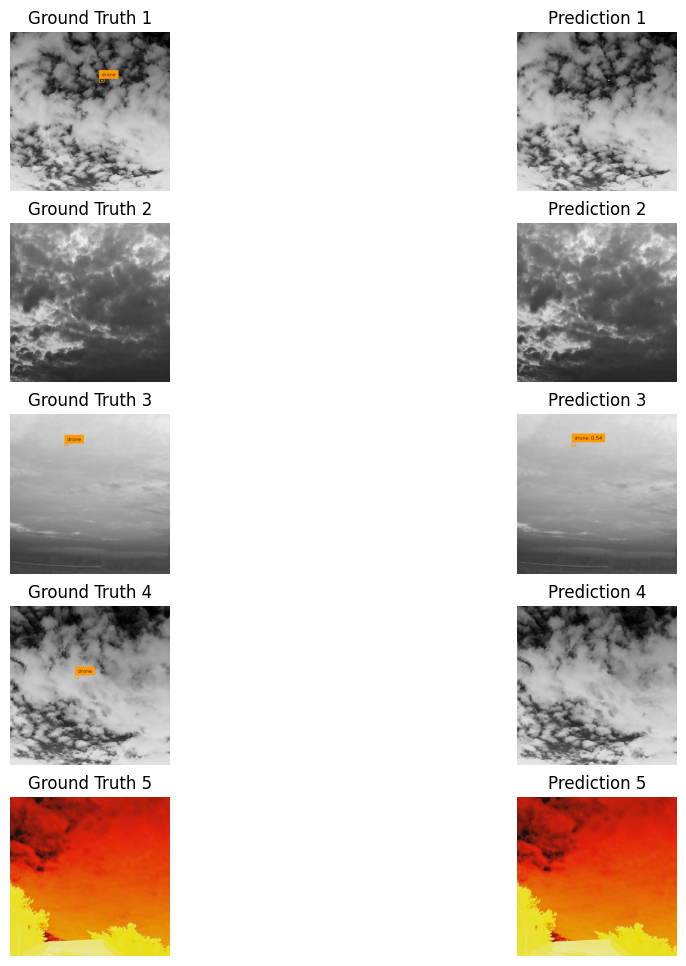

In [28]:
# Visualize predictions vs ground truth
from PIL import Image
import matplotlib.pyplot as plt

images = []
titles = []

# Reduce number of images for faster processing in Colab
num_samples = min(5, len(ds))  # Show 5 samples or less if dataset is smaller

for i in range(num_samples):
    path, image, annotations = ds[i]
    image = Image.open(path)

    # Get predictions
    detections = model.predict(image, threshold=0.5)

    # Calculate optimal visualization parameters
    text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
    thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)
    color = sv.ColorPalette.from_hex([
        "#ffff00", "#ff9b00", "#ff66ff", "#3399ff", "#ff66b2", "#ff8080",
        "#b266ff", "#9999ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
    ])

    # Create annotators
    bbox_annotator = sv.BoxAnnotator(color=color, thickness=thickness)
    label_annotator = sv.LabelAnnotator(
        color=color,
        text_color=sv.Color.BLACK,
        text_scale=text_scale
    )

    # Create labels
    annotations_labels = [
        f"{ds.classes[class_id]}"
        for class_id in annotations.class_id
    ]

    detections_labels = [
        f"{ds.classes[class_id]} {confidence:.2f}"
        for class_id, confidence
        in zip(detections.class_id, detections.confidence)
    ]

    # Annotate ground truth
    annotation_image = image.copy()
    annotation_image = bbox_annotator.annotate(annotation_image, annotations)
    annotation_image = label_annotator.annotate(annotation_image, annotations, annotations_labels)

    # Annotate predictions
    detections_image = image.copy()
    detections_image = bbox_annotator.annotate(detections_image, detections)
    detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

    images.extend([annotation_image, detections_image])
    titles.extend([f"Ground Truth {i+1}", f"Prediction {i+1}"])

# Plot results
sv.plot_images_grid(images=images, grid_size=(num_samples, 2), titles=titles)

In [29]:
import supervision as sv
from tqdm import tqdm
from supervision.metrics import MeanAveragePrecision

targets = []
predictions = []

for path, image, annotations in tqdm(ds):
    image = Image.open(path)
    detections = model.predict(image, threshold=0.5)

    targets.append(annotations)
    predictions.append(detections)

100%|██████████| 10/10 [00:01<00:00,  5.03it/s]


In [30]:
map_metric = MeanAveragePrecision()
map_result = map_metric.update(predictions, targets).compute()
print(map_result)

Average Precision (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
Average Precision (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
Average Precision (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
Average Precision (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
Average Precision (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]                 = -1.000
Average Precision (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ]                 = -1.000
